# Cinema Analytics and Prediction System - Revenue prediction

## 1. Pre-processing

In [1]:
# Import necessary libraries
import json
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, Pool
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

In [2]:
# define constants
value_nearzero = 0.01

### Helper functions

In [3]:
#  Signed log transformation
def get_signed_log(x):
    if pd.isna(x):
        return np.nan
    elif x >= 0:
        return np.log1p(x)
    else:
        return -np.log1p(abs(x))

In [4]:
def get_first_label(x):
    if isinstance(x, str) and len(x.strip()) > 0:
        try:
            labels = ast.literal_eval(x)
            if isinstance(labels, list) and len(labels) > 0:
                return labels[0]
        except (ValueError, SyntaxError):
            return "Unknown"
    elif isinstance(x, list) and len(x) > 0:
        return x[0]
    return "Unknown"

In [5]:
def get_main_genre(x):
    if isinstance(x, str) and len(x.strip()) > 0:
        try:
            genres = ast.literal_eval(x)
            if isinstance(genres, list) and len(genres) > 0:
                return genres[0]
        except (ValueError, SyntaxError):
            return "Unknown"
    elif isinstance(x, list) and len(x) > 0:
        return x[0]
    return "Unknown"

In [6]:
def inverse_log(x):
    if pd.isna(x):
        return np.nan
    elif x >= 0:
        return np.expm1(x)
    else:
        return -np.expm1(abs(x))

In [7]:
def get_movie_season(month):
    if month in [5, 6, 7]:
        return "Summer_Blockbuster"
    elif month in [11, 12]:
        return "Holiday_Season"
    elif month in [1, 2, 9]:
        return "Off_Season"
    else:
        return "Regular"

In [8]:
def categorize_budget(row):
    if row['budget_corrected'] < 0.01:
        return "VLow"
    elif row['budget_corrected'] < 1:
        return "Low"
    elif row['budget_corrected'] < 100:
        return "Avg"
    elif row['budget_corrected'] < 200:
        return "High"
    else:
        return "VH"

In [9]:
def plot_budget_category(category, ymax):
    plt.figure(figsize=(8,4))
    plt.ylim(0,ymax)
    plt.hist(movies[movies['budget_category'] == category]['budget_corrected'], bins=100, edgecolor='k')
    plt.xlabel("Budget (Millions USD)")
    plt.title(f"{category} Distribution of Movies")
    plt.show()

### Data Loading/merging

In [10]:
# Load CSV files combined (movies + credits) from eda.ipynb

movies_df = pd.read_csv('../data/merged_data.csv')
print(movies_df.shape)

#Load CSV file from tmdb details recived by API call
movies_tmdb_df = pd.read_csv('../data/budget_revenue_tmdb.csv')
print(movies_tmdb_df.shape)

(4803, 28)
(3618, 4)


In [11]:
print(len(movies_df[movies_df['budget'] < value_nearzero]))

1037


In [12]:
print(len(movies_tmdb_df[movies_tmdb_df['budget_tmdb'] < value_nearzero]))

0


In [13]:
movies_tmdb_df.isna().sum()

movie_id        0
movie_title     0
budget_tmdb     0
revenue_tmdb    0
dtype: int64

In [14]:
movies_df.isna().sum()

budget                          0
genres                          0
homepage                     3091
movie_id                        0
keywords                        0
original_language               0
original_title                  0
overview                        3
popularity                      0
production_companies            0
production_countries            0
release_date                    1
revenue                         0
runtime                         2
spoken_languages                0
status                          0
tagline                       844
movie_title                     0
vote_average                    0
vote_count                      0
title                           0
cast                            0
crew                            0
release_year                    1
release_month                   1
genre_labels                    0
top_cast                        0
production_companies_list       0
dtype: int64

In [15]:
movies_full_df = movies_df.merge(movies_tmdb_df[['movie_id', 'budget_tmdb', 'revenue_tmdb']],
                                 on='movie_id', how='outer')

### Data cleaning/transformation

In [16]:
def choose_budget(row):
    budget_tmdb = row['budget_tmdb']
    budget = row['budget']    

    if budget_tmdb != 0 and (not pd.isna(budget_tmdb)):
        if (budget < value_nearzero):
            return budget_tmdb             
        elif (budget_tmdb > 2*budget):
            return budget_tmdb        
    return budget

In [17]:
def choose_revenue(row):
    revenue_tmdb = row['revenue_tmdb']
    revenue = row['revenue']   

    if revenue_tmdb != 0 and (not pd.isna(revenue_tmdb)):
        if (revenue < value_nearzero):
            return revenue_tmdb            
        elif (revenue_tmdb > 2*revenue):
            return revenue_tmdb       
    return revenue

In [18]:
movies_full_df['budget'] = movies_full_df.apply(choose_budget, axis=1)
movies_full_df['revenue'] = movies_full_df.apply(choose_revenue, axis=1)

In [19]:
print(movies_full_df.shape)
print(len(movies_full_df[movies_full_df['budget'] < value_nearzero]))
print(len(movies_full_df[movies_full_df['revenue'] < value_nearzero]))
print(len(movies_full_df[movies_full_df['budget'] == 0]))
print(len(movies_full_df[movies_full_df['revenue'] == 0]))

(4803, 30)
662
859
662
859


In [20]:
movies_full_df.isna().sum()

budget                          0
genres                          0
homepage                     3091
movie_id                        0
keywords                        0
original_language               0
original_title                  0
overview                        3
popularity                      0
production_companies            0
production_countries            0
release_date                    1
revenue                         0
runtime                         2
spoken_languages                0
status                          0
tagline                       844
movie_title                     0
vote_average                    0
vote_count                      0
title                           0
cast                            0
crew                            0
release_year                    1
release_month                   1
genre_labels                    0
top_cast                        0
production_companies_list       0
budget_tmdb                  1185
revenue_tmdb  

In [21]:
# Convert string to list for genre_labels
movies_full_df["genre_labels"] = movies_full_df["genre_labels"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [22]:
# load CPI dataset to correct budget/revenue for inflation
cpi = pd.read_csv("../data/flat-ui__data-Wed Jul 02 2025.csv")
cpi['Date'] = pd.to_datetime(cpi['Date'])

In [23]:
cpi = cpi.rename(columns={'Index': 'CPI'})
cpi.drop(columns=['Inflation'], inplace=True)
print(cpi.head())

        Date      CPI
0 2023-12-01  306.746
1 2023-11-01  307.051
2 2023-10-01  307.671
3 2023-09-01  307.789
4 2023-08-01  307.026


In [24]:
movies_full_df.shape

(4803, 30)

In [25]:
movies_full_df.columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'movie_title', 'vote_average', 'vote_count', 'title', 'cast', 'crew',
       'release_year', 'release_month', 'genre_labels', 'top_cast',
       'production_companies_list', 'budget_tmdb', 'revenue_tmdb'],
      dtype='object')

In [26]:
# drop colums not required for revenue prediction
movies = movies_full_df.drop(columns=['homepage', 'movie_id','keywords', 'movie_title'])

In [27]:
# Print colums with nan
nan_df = movies.isna().sum()
nan_nonzero = nan_df[nan_df > 0]
print("Features with NaN:", nan_nonzero.index.tolist())

Features with NaN: ['overview', 'release_date', 'runtime', 'tagline', 'release_year', 'release_month', 'budget_tmdb', 'revenue_tmdb']


In [28]:
# print number of movies with budget not available (=0)
print(len(movies[movies['budget'] == 0]))
# Remove Movies With Budget = 0
movies = movies[movies['budget'] > 0].reset_index(drop=True)

662


In [29]:
# Keep only rows where status is 'Released'
movies = movies[(movies["status"] == "Released")].reset_index(drop=True)

In [30]:
movies.shape

(4138, 26)

### Create new features

In [31]:
# Inflation correction
# Get current CPI index
cpi_May_2025 = 320.580 # current value from https://fred.stlouisfed.org/series/CPIAUCSL
million = 1e6

In [32]:
movies['release_date'] = pd.to_datetime(movies['release_date'])
# Round to the first day of the release month to match with CPI date
movies['cpi_date'] = movies['release_date'].values.astype('datetime64[M]')

In [33]:
# Merge CPI to movies
movies = movies.merge(cpi, left_on='cpi_date',  right_on='Date', how='left')
movies.drop(columns=['Date'], inplace=True)

print(movies.shape)

(4138, 28)


In [34]:
# Get the correction multiplier for each movie
movies["cpi_multiplier"] = cpi_May_2025 / movies["CPI"]
# Correct budget and revenue
movies["revenue_corrected"] = movies["revenue"] * movies["cpi_multiplier"]/million
movies["budget_corrected"] = movies["budget"] * movies["cpi_multiplier"]/million

In [35]:
upper = movies["revenue_corrected"].quantile(0.99)
movies["revenue_cap"] = np.where(
    movies["revenue_corrected"] > upper,
    upper,
    movies["revenue_corrected"]
)

In [36]:
movies.iloc[0]

budget                                                             237000000.0
genres                       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
original_language                                                           en
original_title                                                          Avatar
overview                     In the 22nd century, a paraplegic Marine is di...
popularity                                                          150.437577
production_companies         [{"name": "Ingenious Film Partners", "id": 289...
production_countries         [{"iso_3166_1": "US", "name": "United States o...
release_date                                               2009-12-10 00:00:00
revenue                                                           2787965087.0
runtime                                                                  162.0
spoken_languages             [{"iso_639_1": "en", "name": "English"}, {"iso...
status                                              

## Feature Engineering

In [37]:
# movies['budget_category'] = movies.apply(categorize_budget, axis=1)

#### Budget binning

In [38]:
# Reshape for sklearn
budgets_reshaped = movies[['budget_corrected']].values

# Initialize bin centers
initial_centers = np.array([[0.1], [1], [10], [50], [100], [150], [200], [300], [400],[500]])
# Fit KMeans
kmeans = KMeans(n_clusters=10, init=initial_centers, n_init=1)

#kmeans = KMeans(n_clusters=5, random_state=42)
movies['budget_category'] = kmeans.fit_predict(budgets_reshaped)

# Get cluster centers
centers = kmeans.cluster_centers_.flatten()

print("Cluster centers (millions):", centers)

# Sort centers so lowest center is bin 0
sorted_indices = np.argsort(centers)
labels = ['C0','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Check length
if len(labels) != len(centers):
    raise ValueError("Number of labels must match number of clusters!")
    
bin_label_map = {bin_number: labels[rank] 
                 for rank, bin_number in enumerate(sorted_indices)}

bin_center_map = {labels[rank]: centers[bin_number]
                 for rank, bin_number in enumerate(sorted_indices)}

# Map numeric bins to names
movies['budget_bin_label'] = movies['budget_category'].map(bin_label_map)


Cluster centers (millions): [   6.09445345   22.92241255   41.30114725   62.88906236   93.99453803
  133.44758708  184.99306169  248.51850467  355.32151481 1696.69254857]


In [39]:
movies['budget_category'].value_counts()

0    971
1    852
2    662
3    529
4    448
5    330
6    182
7    130
8     33
9      1
Name: budget_category, dtype: int64

In [40]:
movies['budget_bin_label'].value_counts()

C0    971
C1    852
C2    662
C3    529
C4    448
C5    330
C6    182
C7    130
C8     33
C9      1
Name: budget_bin_label, dtype: int64

In [41]:
bin_center_map

{'C0': 6.0944534487519135,
 'C1': 22.922412551561536,
 'C2': 41.30114725178921,
 'C3': 62.88906236259143,
 'C4': 93.99453803233274,
 'C5': 133.44758708494328,
 'C6': 184.9930616943742,
 'C7': 248.51850466927826,
 'C8': 355.3215148143183,
 'C9': 1696.6925485714282}

In [42]:
bin_label_map

{0: 'C0',
 1: 'C1',
 2: 'C2',
 3: 'C3',
 4: 'C4',
 5: 'C5',
 6: 'C6',
 7: 'C7',
 8: 'C8',
 9: 'C9'}

In [43]:
'''# Plot clusters
plt.figure(figsize=(8, 2))
plt.scatter(
    movies['budget_corrected'],
    np.zeros_like(movies['budget_corrected']),
    c=movies['budget_category'],
    cmap='tab10',
    s=200,
    edgecolor='k'
)
for i, row in movies.iterrows():
    plt.text(row['budget_corrected'], 0.02, f"${row['budget_corrected']}M", ha='center', fontsize=9)
plt.xlabel('Budget (Millions USD)')
plt.yticks([])
plt.title('Budget Clusters via KMeans')
plt.show()'''

'# Plot clusters\nplt.figure(figsize=(8, 2))\nplt.scatter(\n    movies[\'budget_corrected\'],\n    np.zeros_like(movies[\'budget_corrected\']),\n    c=movies[\'budget_category\'],\n    cmap=\'tab10\',\n    s=200,\n    edgecolor=\'k\'\n)\nfor i, row in movies.iterrows():\n    plt.text(row[\'budget_corrected\'], 0.02, f"${row[\'budget_corrected\']}M", ha=\'center\', fontsize=9)\nplt.xlabel(\'Budget (Millions USD)\')\nplt.yticks([])\nplt.title(\'Budget Clusters via KMeans\')\nplt.show()'

In [44]:
# Convert highly skewed feature to log scale
movies["log_budget"] = np.log1p(movies["budget_corrected"]) 
movies["log_revenue"] = np.log1p(movies["revenue_corrected"])

# Convert to sin/cos to capture seasonality
movies['month_sin'] = np.sin(2 * np.pi * movies['release_month'] / 12)
movies['month_cos'] = np.cos(2 * np.pi * movies['release_month'] / 12)

In [45]:
#print(movies.describe())

In [46]:
movies.columns

Index(['budget', 'genres', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count', 'title', 'cast', 'crew',
       'release_year', 'release_month', 'genre_labels', 'top_cast',
       'production_companies_list', 'budget_tmdb', 'revenue_tmdb', 'cpi_date',
       'CPI', 'cpi_multiplier', 'revenue_corrected', 'budget_corrected',
       'revenue_cap', 'budget_category', 'budget_bin_label', 'log_budget',
       'log_revenue', 'month_sin', 'month_cos'],
      dtype='object')

In [47]:
movies['title_len'] = movies['title'].apply( lambda x: len(x) if pd.notna(x) else 0)
movies['overview_len'] = movies['overview'].apply( lambda x: len(x) if pd.notna(x) else 0)
movies['tagline_len'] = movies['tagline'].apply( lambda x: len(x) if pd.notna(x) else 0)

In [48]:
movies["main_genre"] = movies["genre_labels"].apply(lambda s: s[0] if isinstance(s, list) and len(s) > 0 else "Unknown")

# label encode main genre
le = LabelEncoder()
movies["main_genre_label"] = le.fit_transform(movies["main_genre"])

In [49]:
movies["main_genre"].value_counts()

Drama              991
Comedy             888
Action             701
Adventure          330
Horror             261
Crime              178
Thriller           153
Animation          115
Fantasy            112
Science Fiction     89
Romance             87
Family              47
Documentary         47
Mystery             33
Music               30
Western             24
War                 22
History             22
Unknown              5
Foreign              2
TV Movie             1
Name: main_genre, dtype: int64

In [50]:
movies["movie_season"] = movies["release_month"].apply(get_movie_season)
print(movies["movie_season"].value_counts())


Regular               1365
Off_Season            1072
Summer_Blockbuster     980
Holiday_Season         721
Name: movie_season, dtype: int64


In [51]:
movies.shape

(4138, 44)

In [52]:
# impute runtime NaN with median runtime grouped on the original language
median_runtime_by_lang = movies.groupby('original_language')['runtime'].median()

In [53]:
print("en runtime:", median_runtime_by_lang['en'])
print("hi runtime:", median_runtime_by_lang['hi'])

en runtime: 105.0
hi runtime: 156.0


In [54]:
# Impute missing runtime
def impute_runtime(row):
    if pd.isna(row['runtime']):
        return median_runtime_by_lang[row['original_language']]
    else:
        return row['runtime']
movies['runtime'] = movies.apply(impute_runtime, axis=1)

In [55]:
# Print colums with nan
nan_df = movies.isna().sum()
nan_features = nan_df[nan_df > 0]
print("Features with NaN:", nan_features.index.tolist())

Features with NaN: ['overview', 'tagline', 'budget_tmdb', 'revenue_tmdb']


### Revenue Analysis

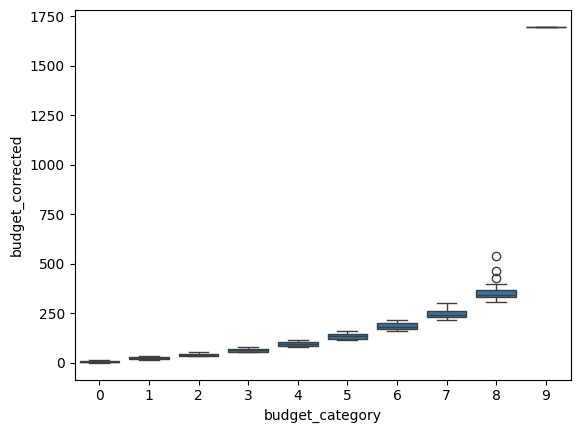

In [56]:
sns.boxplot(x='budget_category', y='budget_corrected', data=movies)
plt.show()

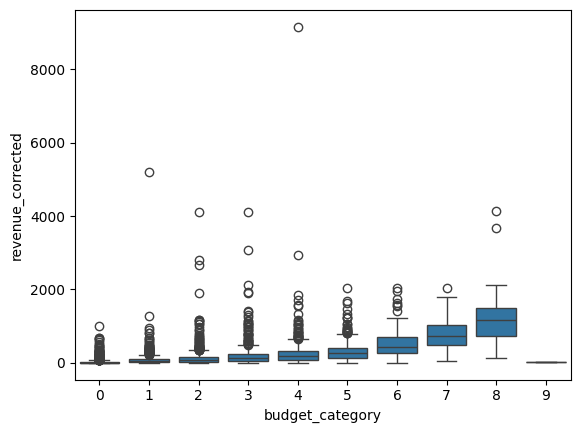

In [57]:
sns.boxplot(x='budget_category', y='revenue_corrected', data=movies)
plt.show()

In [58]:
movies['budget_category'].unique()

array([8, 7, 6, 5, 2, 1, 3, 4, 0, 9])

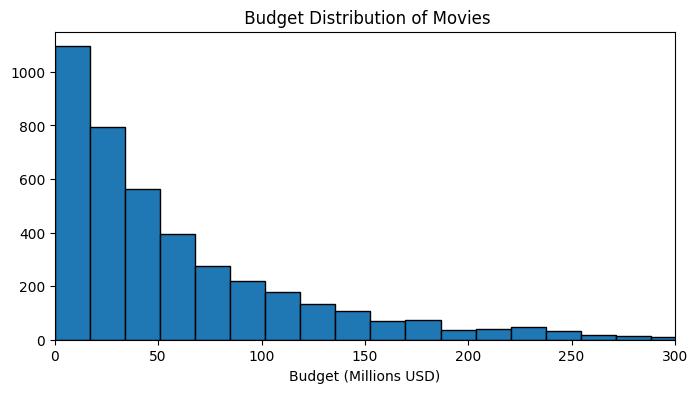

In [59]:
plt.figure(figsize=(8,4))
plt.hist(movies['budget_corrected'], bins=100, edgecolor='k')
plt.xlim(0,300)
plt.xlabel("Budget (Millions USD)")
plt.title(f" Budget Distribution of Movies")
plt.show()

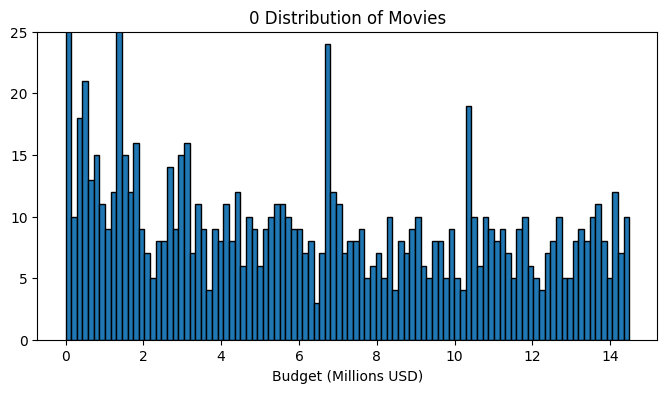

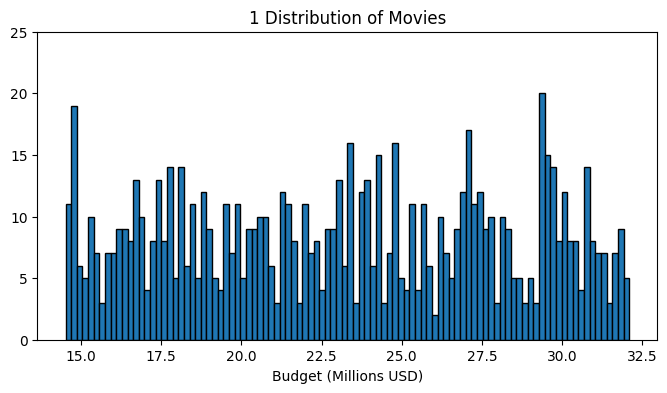

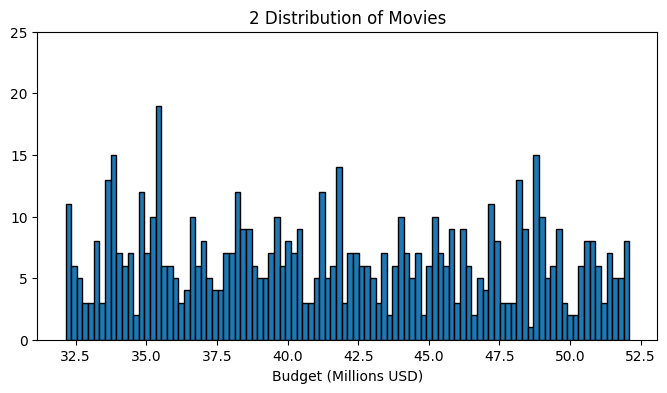

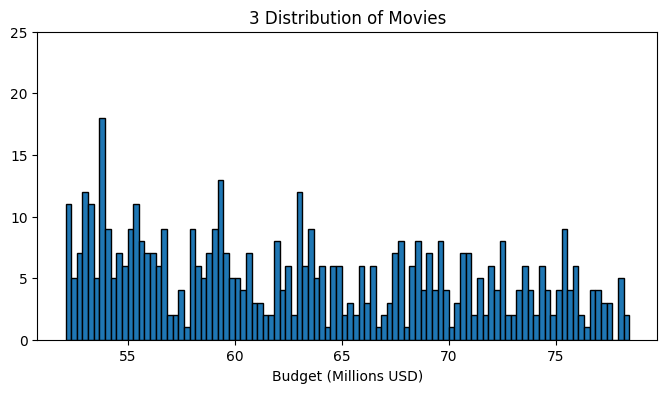

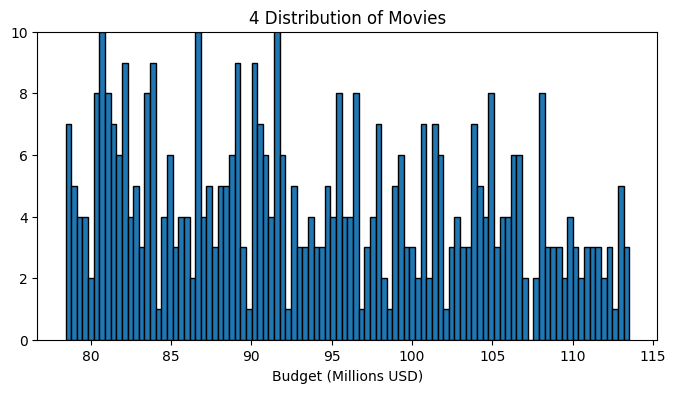

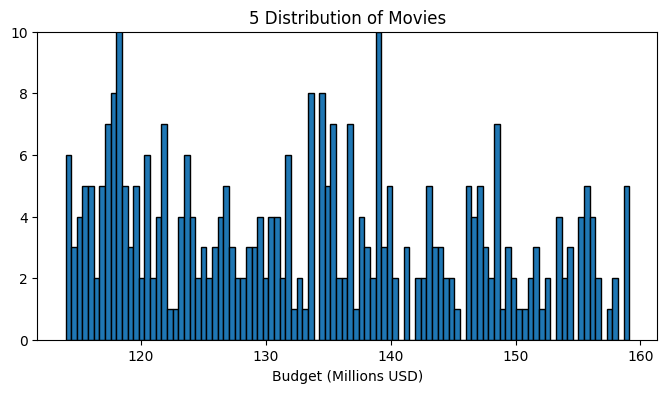

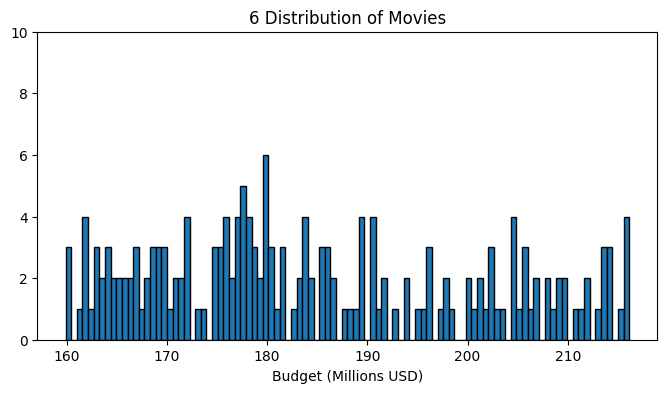

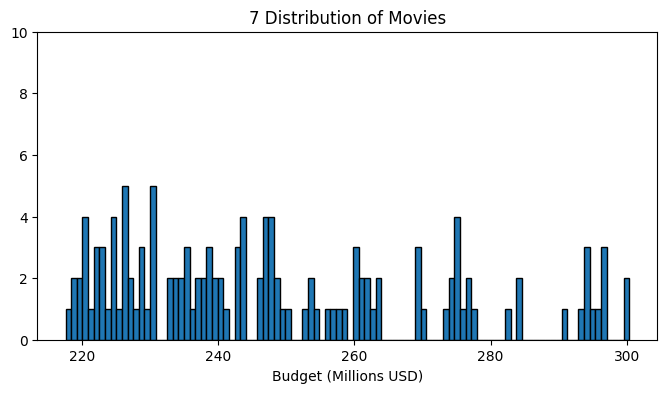

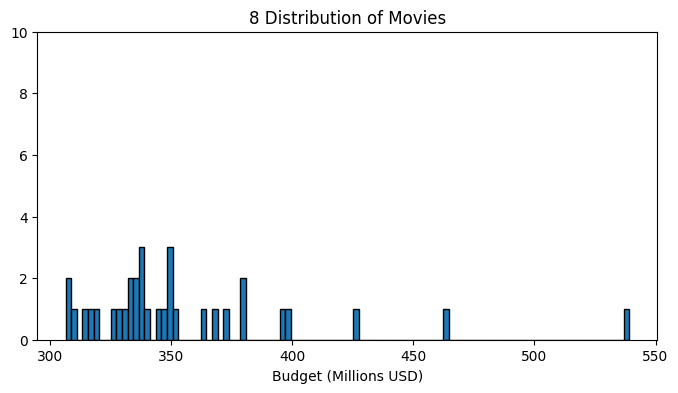

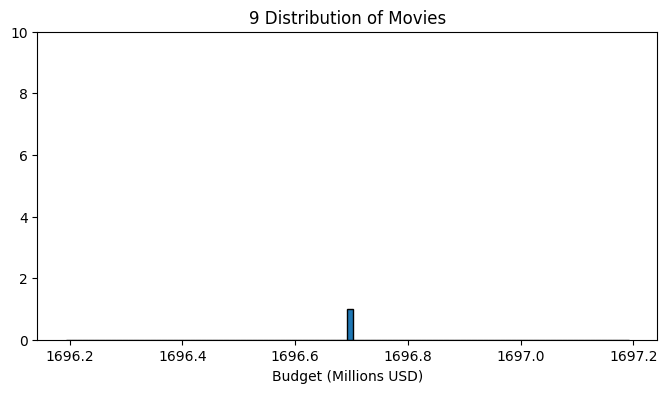

In [60]:
cat_scale = [25,25,25,25,10,10,10,10,10,10]
for cat in range(len(movies['budget_category'].unique())):
    plot_budget_category(cat, cat_scale[cat])

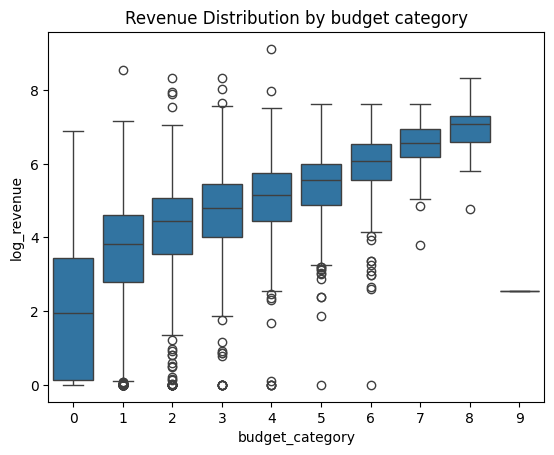

In [61]:
sns.boxplot(
    x="budget_category",
    y="log_revenue",
    data=movies
)

plt.title("Revenue Distribution by budget category")
plt.show()


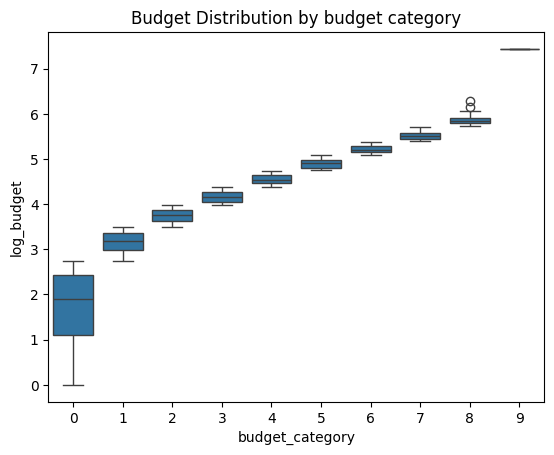

In [62]:
sns.boxplot(
    x="budget_category",
    y="log_budget",
    data=movies
)

plt.title("Budget Distribution by budget category")
plt.show()

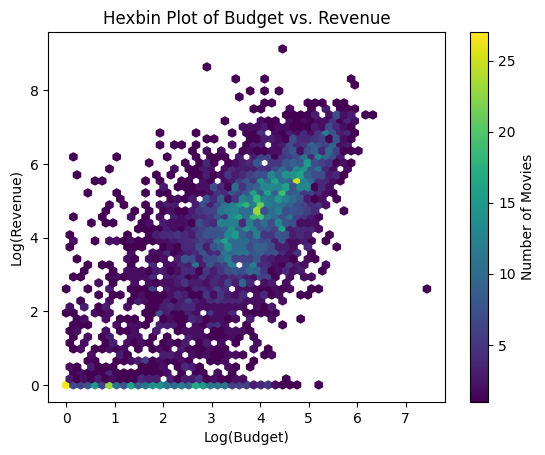

In [63]:
plt.hexbin(movies["log_budget"], movies["log_revenue"],
    gridsize=50,
    cmap='viridis',
    mincnt=1
)
plt.colorbar(label='Number of Movies')
plt.xlabel("Log(Budget)")
plt.ylabel("Log(Revenue)")
plt.title("Hexbin Plot of Budget vs. Revenue")
plt.show()


### Scaling

In [64]:
le_season = LabelEncoder()
movies["season_encoded"] = le_season.fit_transform(movies["movie_season"])

In [65]:
# Encode budget category
le_budget_cat = LabelEncoder()
movies["budget_category_encoded"] = le_budget_cat.fit_transform(movies["budget_category"])

In [66]:
#features_to_scale = ['budget', 'popularity', 'revenue', 'profit', 'runtime', 'vote_average', 'vote_count', 'log_budget', 'log_revenue', 'log_profit', 'ROI', 'log_ROI']
'''
features_to_scale = [
    'log_budget',    
    'popularity',    
    'runtime',
    'vote_count',
]
feature_scaler = StandardScaler()
movies_scaled = movies.copy()
movies_scaled[features_to_scale] = feature_scaler.fit_transform(movies[features_to_scale])

target_to_scale = ['log_revenue']
target_scaler = StandardScaler()
movies_scaled[target_to_scale] = target_scaler.fit_transform(movies[target_to_scale])'''

"\nfeatures_to_scale = [\n    'log_budget',    \n    'popularity',    \n    'runtime',\n    'vote_count',\n]\nfeature_scaler = StandardScaler()\nmovies_scaled = movies.copy()\nmovies_scaled[features_to_scale] = feature_scaler.fit_transform(movies[features_to_scale])\n\ntarget_to_scale = ['log_revenue']\ntarget_scaler = StandardScaler()\nmovies_scaled[target_to_scale] = target_scaler.fit_transform(movies[target_to_scale])"

In [68]:
'''print(movies_scaled[features_to_scale].loc[0])
print(movies_scaled[target_to_scale].loc[0])'''

'print(movies_scaled[features_to_scale].loc[0])\nprint(movies_scaled[target_to_scale].loc[0])'

### Budget Classifier



In [69]:
features = ["budget_corrected"]

In [70]:
movies["budget_category"].unique()

array([8, 7, 6, 5, 2, 1, 3, 4, 0, 9])

In [71]:
#le_budget_cat.inverse_transform([0,1,2,3,4])

In [72]:
X_class = movies[features]
y_class = movies["budget_category"]

# Train/test split
X_class_train_clf, X_class_test_clf, y_class_train_clf, y_class_test_clf = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,    
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

clf.fit(X_class_train_clf, y_class_train_clf)

# Evaluate
y_class_pred_clf= clf.predict(X_class_test_clf)
print(classification_report(y_class_test_clf, y_class_pred_clf))

C:\Users\bplse\anaconda3\envs\Tf_210_Py_3819_Cuda_112_Cudn_81\lib\site-packages\xgboost\core.py:158: UserWarning: [18:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       172
           2       1.00      1.00      1.00       123
           3       1.00      1.00      1.00       118
           4       1.00      0.99      0.99        88
           5       0.99      1.00      0.99        67
           6       0.98      1.00      0.99        42
           7       1.00      0.93      0.96        29
           8       0.92      1.00      0.96        11

    accuracy                           1.00       828
   macro avg       0.99      0.99      0.99       828
weighted avg       1.00      1.00      1.00       828



In [73]:
bin_center_map

{'C0': 6.0944534487519135,
 'C1': 22.922412551561536,
 'C2': 41.30114725178921,
 'C3': 62.88906236259143,
 'C4': 93.99453803233274,
 'C5': 133.44758708494328,
 'C6': 184.9930616943742,
 'C7': 248.51850466927826,
 'C8': 355.3215148143183,
 'C9': 1696.6925485714282}

In [79]:
class RevenueRegressor:
    def __init__(self, xgb_params=None):       
        
        self.xgb_params = xgb_params if xgb_params is not None else {            
            "n_estimators": 300,
            "max_depth": 3,
            "learning_rate": 0.1,
            "random_state": 42
        }
        self.model = XGBRegressor(**self.xgb_params)
       

    def fit(self, X, y):
        # Fit model
        self.model.fit(X, y)

    def predict(self, X_test):        
        log_y_pred = self.model.predict(X_test)               
        return log_y_pred

    def evaluate(self, X_test, y_true):
       
        log_y_pred = self.predict(X_test)

        rmse = mean_squared_error(y_true, log_y_pred, squared=False)     
        print(f"RMSE (Revenue dollars): ${rmse:,.2f}")
        
        mae = mean_absolute_error(y_true, log_y_pred)
        medae = median_absolute_error(y_true, log_y_pred)
        r2 = r2_score(y_true, log_y_pred)
        
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Median Absolute Error: {medae:.2f}")
        print(f"R2: {r2:.3f}")        
        return log_y_pred

    def plot_residuals(self, y_true, y_pred):
       
        residuals = y_true - y_pred
        print("Mean residual:", residuals.mean())
        print("Std of residuals:", residuals.std())
        plt.figure(figsize=(8,5))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted Revenue ($)")
        plt.ylabel("Residuals ($)")
        plt.title("Residuals vs Predicted Revenue")
        plt.show()
        
    def plot_prediction(self, y_true, y_pred):       
        plt.figure(figsize=(8,5))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Actual Revenue (million$)")
        plt.ylabel("Predicted Revenue (million$)")
        plt.title("Predicted vs Actual Revenue")
        plt.show()

        plt.figure(figsize=(8,5))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.xlim(0,1000)
        plt.ylim(0,1000)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Actual Revenue (million$)")
        plt.ylabel("Predicted Revenue (million $)")
        plt.title("Zoomed Predicted vs Actual Revenue")
        plt.show()

    def save_model(self):
        self.model.save_model("../model/revenue_prediction_xgb_model.json")



In [75]:
def predict_evaluate_revenue(movies, budget_class=None, save=False):
    if budget_class is None:
        budget_class = ['C0']
    print("Budget classes:", budget_class)
    movies_class_df = movies[movies["budget_bin_label"].isin(budget_class)]
    features = [
        "budget_corrected",
        'popularity',
        'runtime',
        'season_encoded',
        'budget_category',
        'main_genre_label',
        'vote_count',
    ]
    target_to_predict = 'revenue_corrected'
    X = movies_class_df[features]
    y = movies_class_df[target_to_predict]
    
    # Split train vs temp
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print("Positive Train size:", len(X_train))
    print("Positive Test size:", len(X_test))
    # Initialize regressor
    regressor_xg = RevenueRegressor()
    
    # Fit model
    regressor_xg.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = regressor_xg.evaluate(X_test, y_test)
    #regressor_xg.plot_residuals(y_test, y_pred)  
    regressor_xg.plot_prediction(y_test, y_pred)
    if save:
        regressor_xg.save_model()
            

Budget classes: ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
Positive Train size: 2895
Positive Test size: 1242
RMSE (Revenue dollars): $255.37
Mean Absolute Error: 105.40
Median Absolute Error: 47.31
R2: 0.465


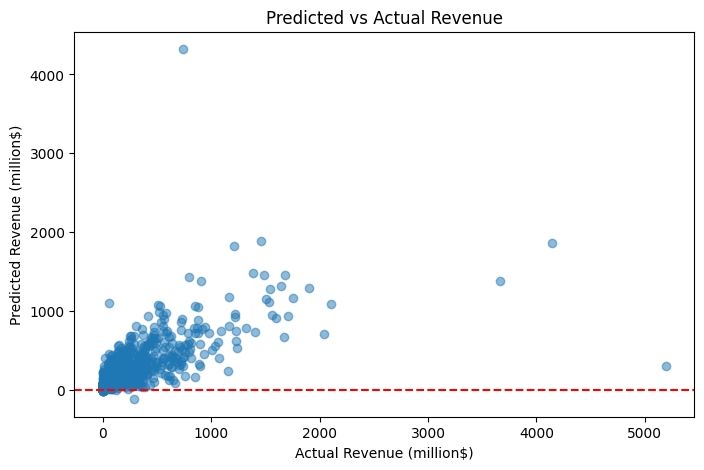

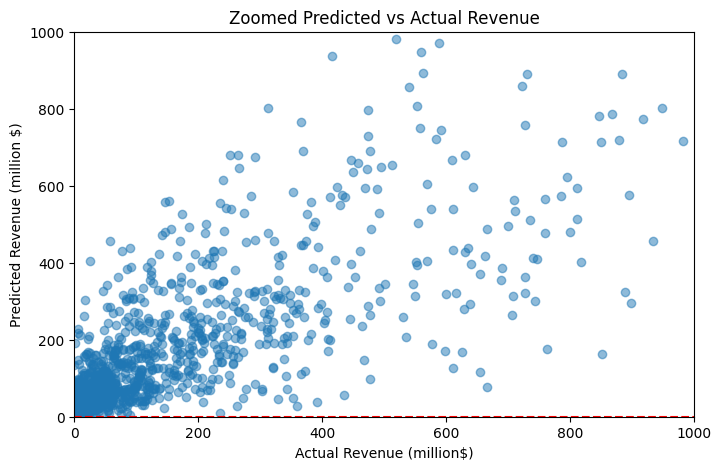

In [76]:
predict_evaluate_revenue(movies, budget_class=[ 'C0','C1','C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'], save=True)

Budget classes: ['C0']
Positive Train size: 679
Positive Test size: 292
RMSE (Revenue dollars): $95.02
Mean Absolute Error: 38.96
Median Absolute Error: 13.29
R2: -0.121


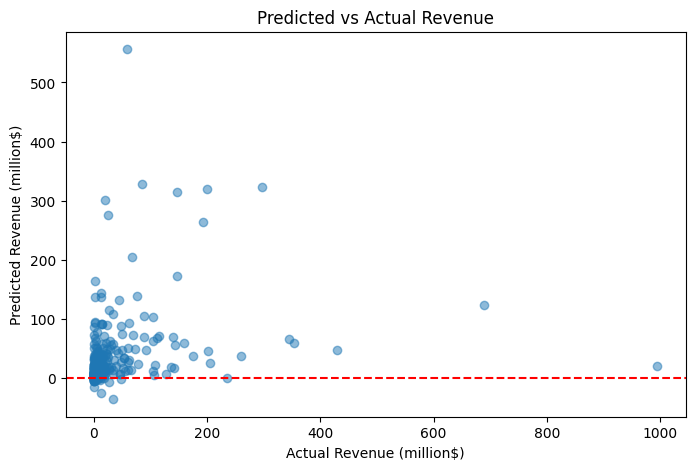

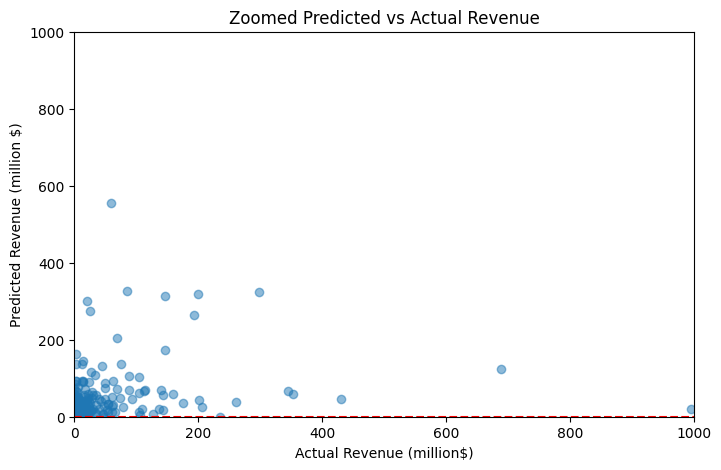

Budget classes: ['C1']
Positive Train size: 596
Positive Test size: 256
RMSE (Revenue dollars): $322.73
Mean Absolute Error: 77.08
Median Absolute Error: 30.73
R2: 0.068


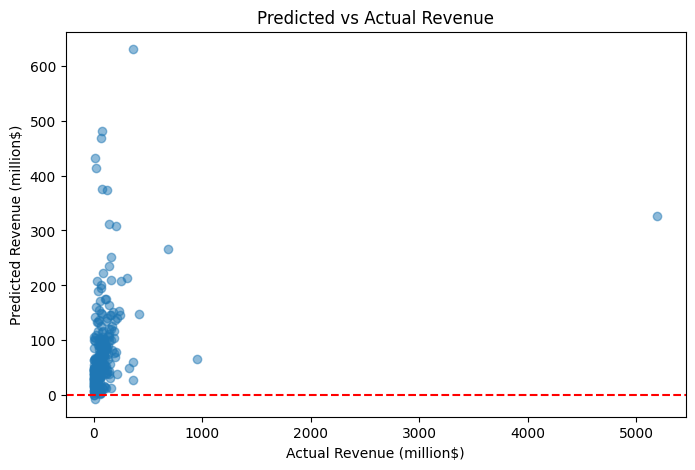

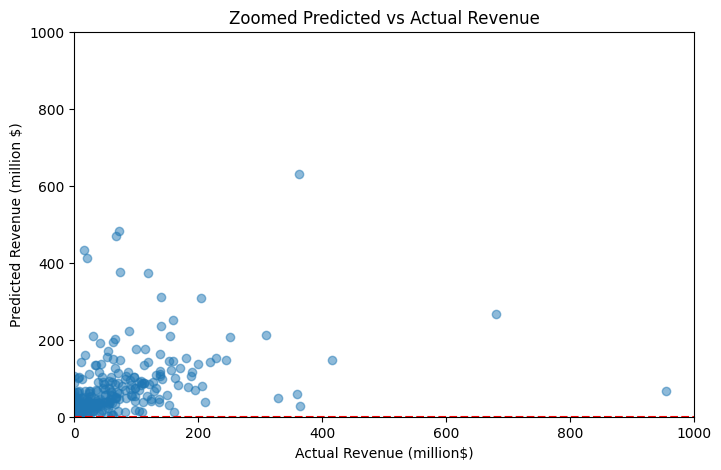

Budget classes: ['C2']
Positive Train size: 463
Positive Test size: 199
RMSE (Revenue dollars): $395.83
Mean Absolute Error: 151.43
Median Absolute Error: 69.48
R2: -0.111


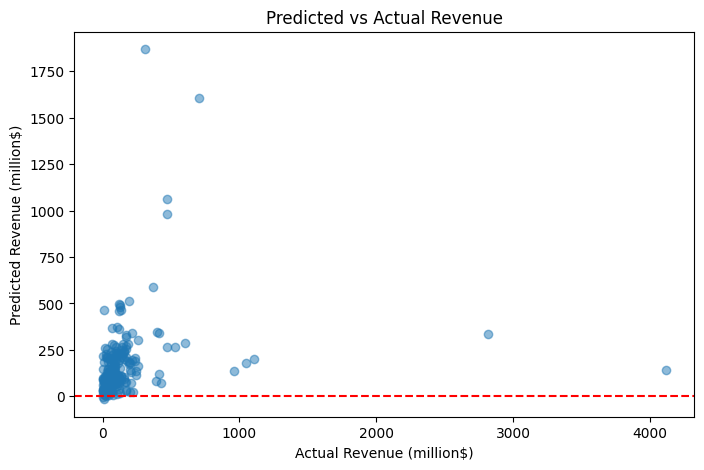

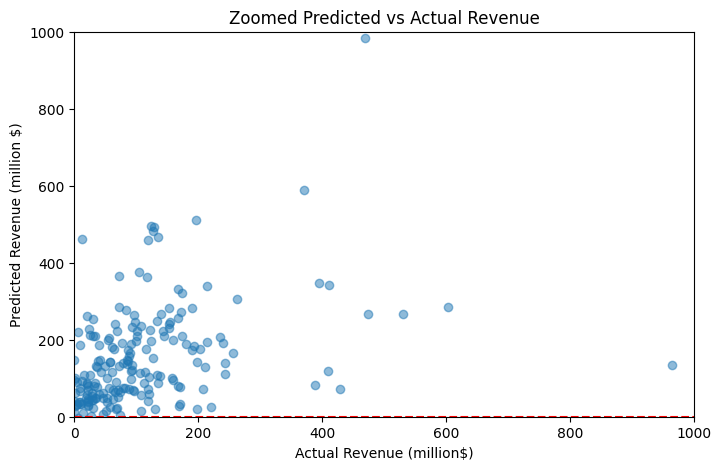

Budget classes: ['C3']
Positive Train size: 370
Positive Test size: 159
RMSE (Revenue dollars): $351.40
Mean Absolute Error: 154.96
Median Absolute Error: 62.07
R2: 0.303


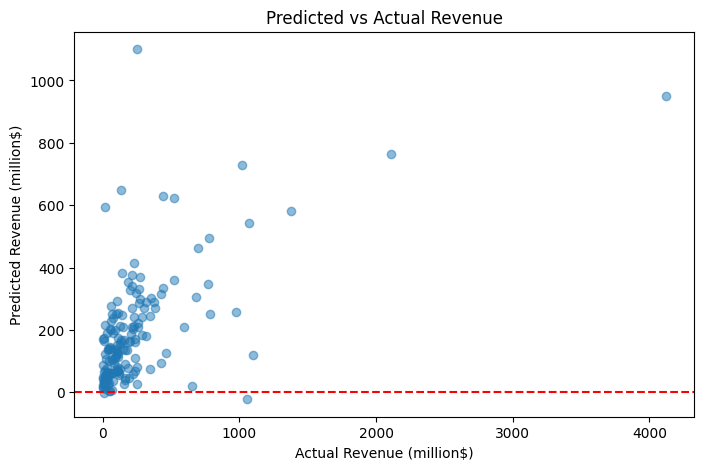

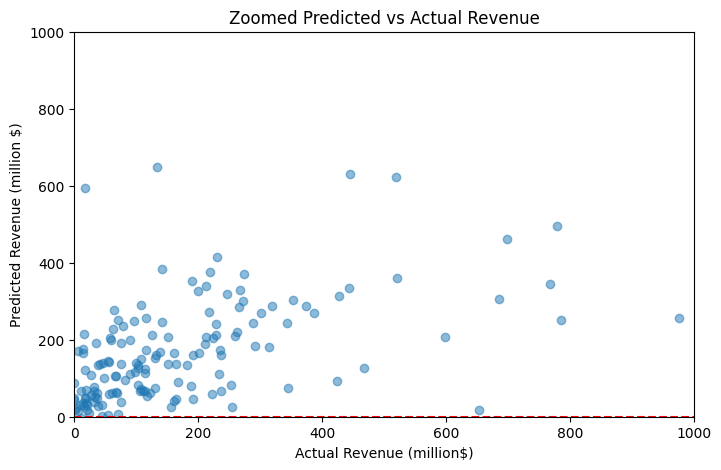

Budget classes: ['C4']
Positive Train size: 313
Positive Test size: 135
RMSE (Revenue dollars): $242.48
Mean Absolute Error: 157.46
Median Absolute Error: 89.81
R2: 0.286


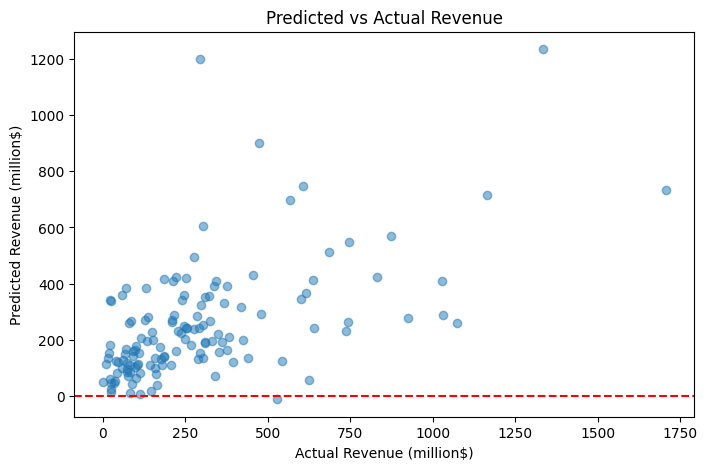

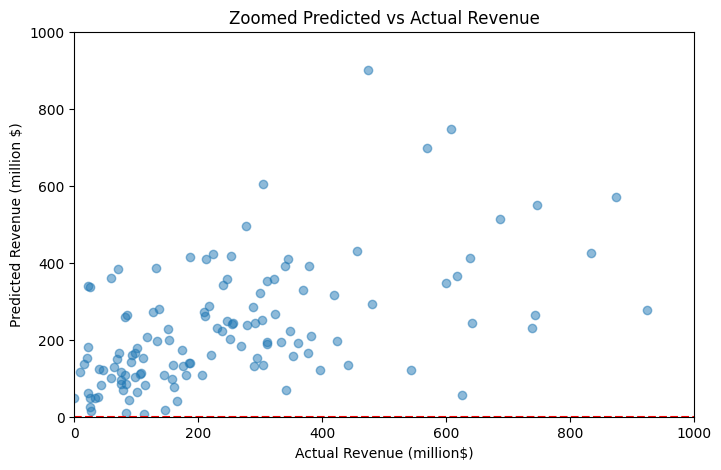

Budget classes: ['C5']
Positive Train size: 231
Positive Test size: 99
RMSE (Revenue dollars): $265.28
Mean Absolute Error: 165.91
Median Absolute Error: 83.55
R2: 0.341


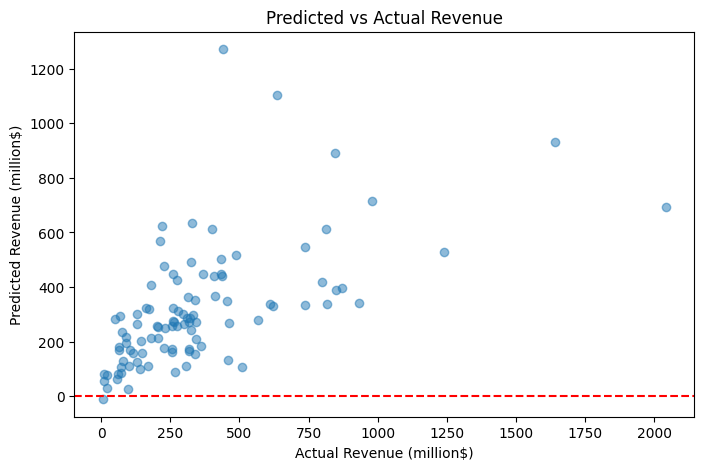

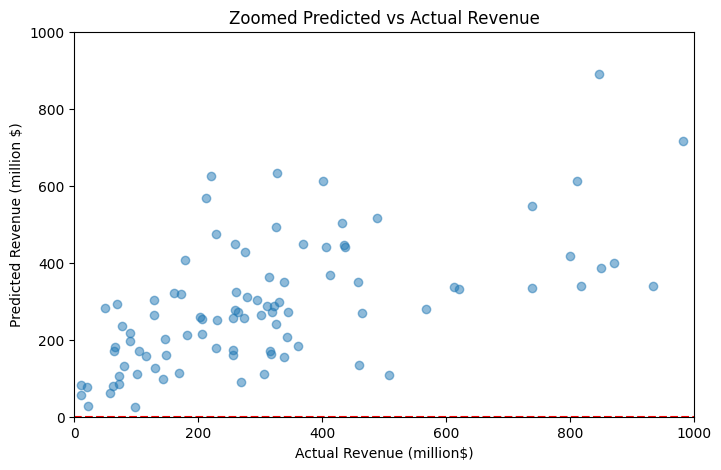

Budget classes: ['C6']
Positive Train size: 127
Positive Test size: 55
RMSE (Revenue dollars): $320.02
Mean Absolute Error: 230.03
Median Absolute Error: 185.11
R2: 0.316


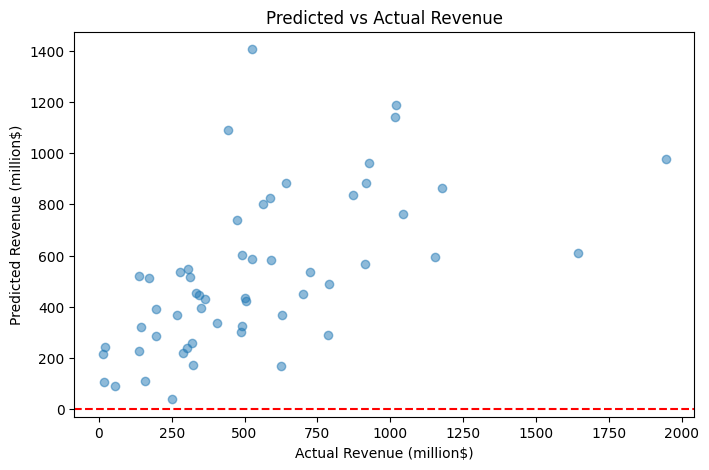

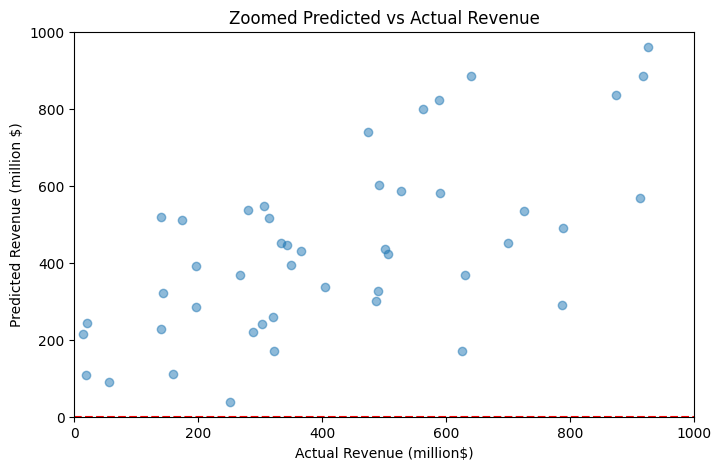

Budget classes: ['C7']
Positive Train size: 91
Positive Test size: 39
RMSE (Revenue dollars): $405.09
Mean Absolute Error: 328.97
Median Absolute Error: 307.34
R2: 0.024


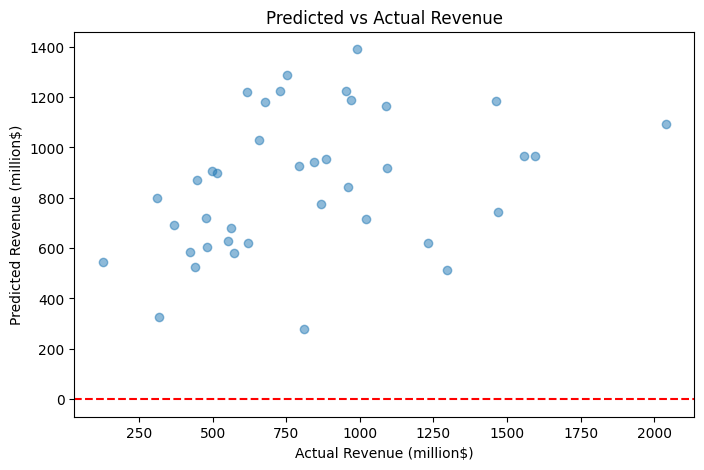

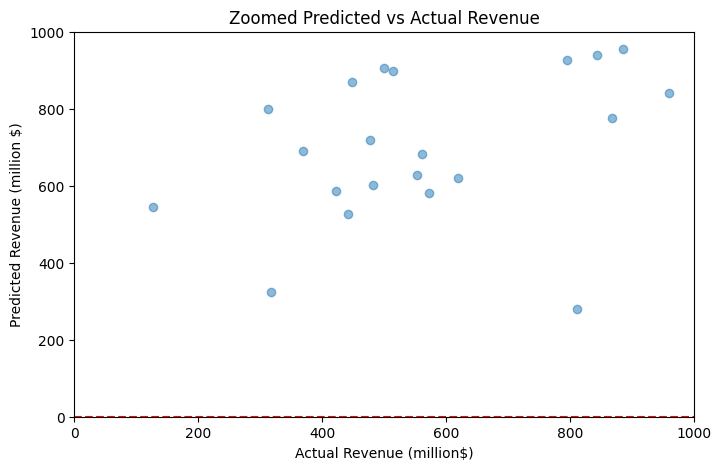

Budget classes: ['C8']
Positive Train size: 23
Positive Test size: 10
RMSE (Revenue dollars): $1,085.88
Mean Absolute Error: 673.27
Median Absolute Error: 334.83
R2: 0.278


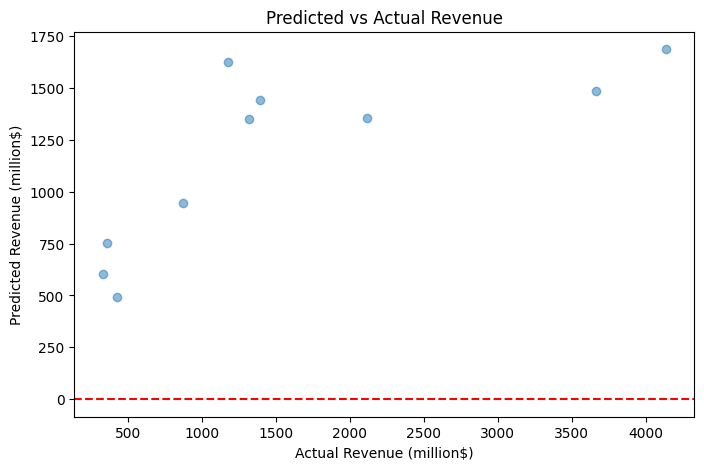

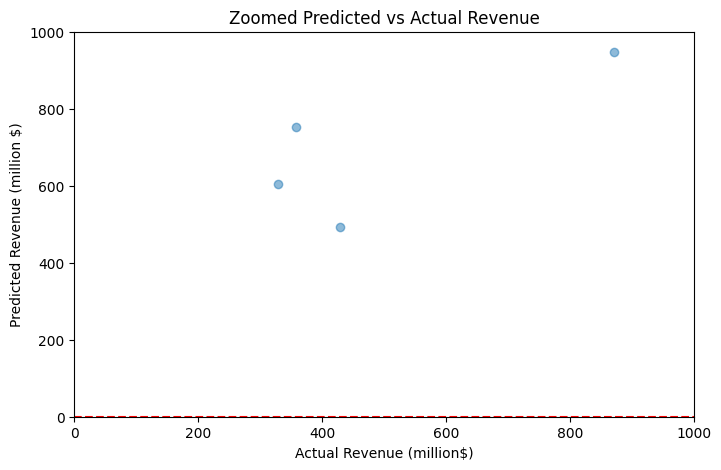

In [77]:
b_cat = movies['budget_bin_label'].unique()
b_cat.sort()
for cat in b_cat:
    if len(movies[movies['budget_bin_label'] == cat]) > 25:
        predict_evaluate_revenue(movies, budget_class=[cat])

In [78]:
#############################################################################################################################################################################